In [1]:
import pysam
import os
import sys
directory_path = os.path.abspath(os.path.join('../src/'))
if directory_path not in sys.path:
    sys.path.append(directory_path)
    
from read_process import get_contig_lengths_dict,\
incorporate_replaced_pos_info,incorporate_insertions_and_deletions,\
get_positions_from_md_tag,reverse_complement,get_edit_information,get_edit_information_wrapper,\
has_edits,get_dataframe_from_barcode_dict


# An example on a bam for just one cell barcode (split from the original bam)

### in 10X's bam file, xf=25 means that read is uniquely mapped to a genome, and was used for counting UMI. So we should only look at reads with xf=25 from the 10X bam.

In [2]:
barcode = 'AAACCCAAGATTGCGG'
bampath = '../data/group0_data/filtered_keep_xf25_possorted_genome_with_header.bam_MD.bam_MD-{}-1.bam'.format(barcode)

In [3]:
samfile = pysam.AlignmentFile(bampath, "rb")

# Helper functions

In [4]:
    
def print_read_info(read):
    md_tag = read.get_tag('MD')
    read_id = read.query_name
    cigar_string = read.cigarstring
    barcode = read.get_tag('CR')
    print('MD tag', md_tag)
    print("CIGAR tag", cigar_string)
    print('barcode', barcode)
    

# Full test

In [119]:
from collections import defaultdict
import time
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

# TOLERANCES/THRESHOLD FOR FILTERING
max_edit_tolerance = 5
dist_from_end_tolerance = 5
base_quality_threshold = 37
mapping_quality_threshold = 255

# DICTIONARIES TO FILL WITH EDIT INFORMATION
barcode_to_position_to_alts = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:defaultdict())))) 
skipped_for_deletions_count = 0 
wrong_barcode = []

example_dataframe_per_contig = {}
contig_lengths_dict = get_contig_lengths_dict(samfile)
contigs = [i for i in contig_lengths_dict.keys() if len(i) < 5]

# THE HEAVY LIFTING
total_edited_reads = 0
coverage_dict = {}
total_non_edited_reads = 0

for contig in contigs:
    contig_length = contig_lengths_dict.get(contig)
    
    position_coverage_tracker_for_contig = np.zeros(contig_length)
    
    print(contig, contig_length)
    reads_for_contig = samfile.fetch(contig, 0, contig_length)

    reads_kept = 0
    for i, read in enumerate(reads_for_contig):
        reference_start = read.reference_start
        reference_end = read.reference_end
        read_id = read.query_name
        
        reference_positions_covered_by_read = read.get_reference_positions()
        position_coverage_tracker_for_contig[reference_positions_covered_by_read] += 1
        
        if not has_edits(read):
            total_non_edited_reads += 1
            #print(reference_positions_covered_by_read)
            continue
            
        if read.is_secondary:
            continue
            
        md_tag = read.get_tag('MD')
            
        is_reverse = read.is_reverse
        strand = '+'
        if is_reverse:
            strand = '-'

        

        if '^' in md_tag:
            # FOR NOW SKIP DELETIONS, THEY ARE TRICKY TO PARSE...
            skipped_for_deletions_count += 1
            continue

        read_barcode = read.get_tag('CR')
        
        # READ FILTERING DONE
        reads_kept += 1
        
        alt_bases, ref_bases, qualities, positions_replaced = get_edit_information_wrapper(read, not is_reverse)
        
        for alt, ref, qual, pos in zip(alt_bases, ref_bases, qualities, positions_replaced):
            assert(alt != ref)
            updated_position = pos+reference_start
            if is_reverse:
                alt = reverse_complement(alt)
                ref = reverse_complement(ref)

            distance_from_read_end = np.min([updated_position - reference_start, reference_end - updated_position])
            
            barcode_to_position_to_alts[read_barcode][contig]['{}_{}'.format(updated_position, ref)]\
            [alt][read_id] = strand, distance_from_read_end, qual
            
        if reads_kept > 100000:
            break
        
        #if total_non_edited_reads > 2:
        #    break
    total_edited_reads += reads_kept
    coverage_dict[contig] = position_coverage_tracker_for_contig


1 195471971
10 130694993
11 122082543
12 120129022
13 120421639
14 124902244
15 104043685
16 98207768
17 94987271
18 90702639
19 61431566
2 182113224
3 160039680
4 156508116
5 151834684
6 149736546
7 145441459
8 129401213
9 124595110
MT 16299
X 171031299
Y 91744698


In [120]:
print("{} total edited reads".format(total_edited_reads))
print("{} total non-edited reads".format(total_non_edited_reads))


6586 total edited reads
27538 total non-edited reads


# BUILD DATATFRAME

In [121]:
example_dataframe = get_dataframe_from_barcode_dict(barcode_to_position_to_alts)
print(len(example_dataframe))

12360


# ADD REFERENCE BASE COUNTS AT POSITION

In [122]:
def get_total_coverage_for_contig_at_position(r, coverage_dict):
    position = r.position
    contig = r.contig
    return coverage_dict.get(contig)[position]
    
example_dataframe['coverage'] = example_dataframe.apply(get_total_coverage_for_contig_at_position, args=(coverage_dict,), axis=1)


In [123]:
example_dataframe

,barcode,contig,position_ref,alt,read_id,strand,dist_from_read_end,quality,ref,position,coverage
0,AAACCCAAGATAGCGG,1,3210993_G,T,A01535:287:H3JJHDSX7:1:1256:24496:23531,-,44,11,G,3210993,1.0
1,AAACCCAAGATAGCGG,1,3210998_C,A,A01535:287:H3JJHDSX7:1:1256:24496:23531,-,39,11,C,3210998,1.0
2,AAACCCAAGATAGCGG,12,116256160_C,A,A01535:287:H3JJHDSX7:1:1301:12545:32581,-,15,11,C,116256160,1.0
3,AAACCCAAGATAGCGG,12,116256165_G,T,A01535:287:H3JJHDSX7:1:1301:12545:32581,-,20,11,G,116256165,1.0
4,AAACCCAAGATAGCGG,14,24493549_T,G,A01535:287:H3JJHDSX7:1:1525:5475:21371,+,79,11,T,24493549,0.0
...,...,...,...,...,...,...,...,...,...,...,...
12355,AAACCCAAGATTGCCG,9,53401686_T,A,A01535:287:H3JJHDSX7:1:1376:17680:11537,+,16,11,T,53401686,1.0
12356,ACACCCAAGATTGCGG,9,73037492_C,A,A01535:287:H3JJHDSX7:1:1622:18059:17112,-,33,11,C,73037492,1.0
12357,ACACCCAAGATTGCGG,9,73037494_G,T,A01535:287:H3JJHDSX7:1:1622:18059:17112,-,31,11,G,73037494,1.0
12358,ACACCCAAGATTGCGG,9,73037495_A,G,A01535:287:H3JJHDSX7:1:1622:18059:17112,-,30,11,A,73037495,1.0


# FILTER DATAFRAME

12360
5569


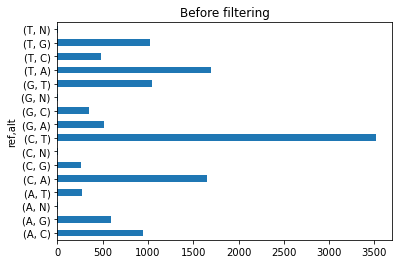

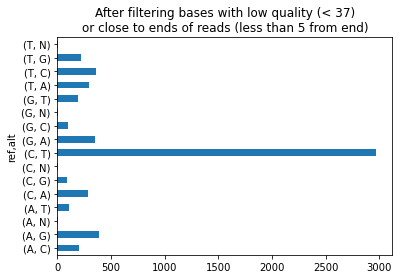

In [125]:
num_edits_per_read = pd.DataFrame(example_dataframe.groupby('read_id').count().barcode)
num_edits_per_read.columns = ['edits']

print(len(example_dataframe))
example_dataframe.groupby(['ref', 'alt']).count().barcode.plot(kind='barh')
plt.title("Before filtering")

"""
plt.figure()
example_dataframe_filtered = example_dataframe[~example_dataframe.read_id.isin(hyperedited_reads.index)]
print(len(example_dataframe_filtered))
example_dataframe_filtered.groupby(['ref', 'alt']).count().barcode.plot(kind='barh')
plt.title("After filtering hyperedited reads (more than {} edits)".format(max_edit_tolerance))
"""

# Filter for distance from read end and base quality
example_dataframe_filtered = example_dataframe[(example_dataframe.dist_from_read_end > dist_from_end_tolerance) & (example_dataframe.quality.astype(int) >= base_quality_threshold)]
print(len(example_dataframe_filtered))
plt.figure()
example_dataframe_filtered.groupby(['ref', 'alt']).count().barcode.plot(kind='barh')
_ = plt.title("After filtering bases with low quality (< {})\nor close to ends of reads (less than {} from end)".format(base_quality_threshold, dist_from_end_tolerance))


In [126]:
example_new_ct =  example_dataframe_filtered[(example_dataframe_filtered.ref == 'C') & (example_dataframe_filtered.alt == 'T')].sort_values('position')

In [127]:
len(example_new_ct)

2972

# Extract only reads for a barcode

In [131]:
# Get edits for barcode

example = pd.read_csv(
    '../data/group0_data/filtered_keep_xf25_possorted_genome_with_header.bam_MD.bam_MD-{}-1.bam.combined.readfiltered.formatted.varfiltered.snpfiltered.ranked.bed'.format(barcode),
    sep='\t', names=['contig', 'start', 'end', 'score', 'coverage', 'strand'])

comparison_vals = []
overlapping_by_contig = {}
for contig in contigs:
    print('contig {}'.format(contig))
    example_new_ct_for_contig = example_new_ct[example_new_ct.contig == contig]
    example_new_ct_for_contig.index = example_new_ct_for_contig.position

    example_old_ct_for_contig = example[example.contig == contig]
    example_old_ct_for_contig.index = example_old_ct_for_contig.start

    # Which overlap?
    
    overlapping = example_old_ct_for_contig.join(example_new_ct_for_contig, rsuffix='_2', how='inner').drop_duplicates(['contig', 'start', 'end', 'score'])
    overlapping['old_coverage'] = [int(v.split(',')[1]) for v in overlapping['coverage']]
    overlapping_by_contig[contig] = overlapping
    print("\tNumber of sites in old version: {}".format(len(example_old_ct_for_contig)))
    print("\tNumber of sites recapitulated: {}".format(len(overlapping)))
    
    comparison_vals.append([len(example_old_ct_for_contig), len(overlapping), len(example_new_ct_for_contig)])


contig 1
	Number of sites in old version: 11
	Number of sites recapitulated: 10
contig 10
	Number of sites in old version: 15
	Number of sites recapitulated: 13
contig 11
	Number of sites in old version: 32
	Number of sites recapitulated: 29
contig 12
	Number of sites in old version: 21
	Number of sites recapitulated: 18
contig 13
	Number of sites in old version: 3
	Number of sites recapitulated: 2
contig 14
	Number of sites in old version: 11
	Number of sites recapitulated: 10
contig 15
	Number of sites in old version: 19
	Number of sites recapitulated: 17
contig 16
	Number of sites in old version: 5
	Number of sites recapitulated: 5
contig 17
	Number of sites in old version: 17
	Number of sites recapitulated: 15
contig 18
	Number of sites in old version: 1
	Number of sites recapitulated: 1
contig 19
	Number of sites in old version: 23
	Number of sites recapitulated: 22
contig 2
	Number of sites in old version: 20
	Number of sites recapitulated: 20
contig 3
	Number of sites in old ver

# Which sites are we recovering?

In [132]:
recapitulation_summary = pd.DataFrame(comparison_vals, index=contigs, columns=['Previous sites', 'Overlapping sites', 'New sites'])

Text(0.5, 1.0, 'Sites from old approach recapitulated with new approach')

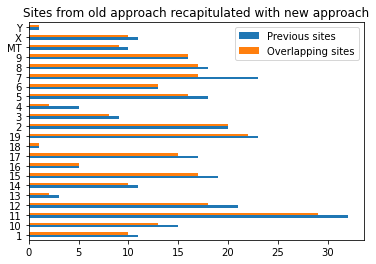

In [133]:
recapitulation_summary[['Previous sites', 'Overlapping sites']].plot(kind='barh')
plt.title("Sites from old approach recapitulated with new approach")

In [147]:
for contig in contigs:
    print(contig)
    corr = overlapping_by_contig.get(contig)[['old_coverage', 'coverage']].corr().iloc[0].iloc[0]
    print('\tCorrelation between old coverage and new coverage values: {}'.format(corr))

1
	Correlation between old coverage and new coverage values: 1.0
10
	Correlation between old coverage and new coverage values: 1.0
11
	Correlation between old coverage and new coverage values: 1.0
12
	Correlation between old coverage and new coverage values: 1.0
13
	Correlation between old coverage and new coverage values: 1.0
14
	Correlation between old coverage and new coverage values: 1.0
15
	Correlation between old coverage and new coverage values: 1.0
16
	Correlation between old coverage and new coverage values: 1.0
17
	Correlation between old coverage and new coverage values: 1.0
18
	Correlation between old coverage and new coverage values: nan
19
	Correlation between old coverage and new coverage values: 1.0
2
	Correlation between old coverage and new coverage values: 1.0
3
	Correlation between old coverage and new coverage values: 1.0
4
	Correlation between old coverage and new coverage values: 1.0
5
	Correlation between old coverage and new coverage values: 1.0
6
	Correlation 